# Correction (Joseph Salmon)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from statsmodels.nonparametric.kde import KDEUnivariate
from scipy.stats import gaussian_kde
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from numpy.linalg import svd

from IPython.display import HTML
from IPython.display import display

%matplotlib inline
# REM: LaTeX needs to be install on the machine for some
#      display to be fined

ModuleNotFoundError: No module named 'seaborn'

# Plot initialization

In [2]:
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': True,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
plt.close("all")

sns.set_palette("colorblind")
sns.axes_style()
sns.set_style({'legend.frameon': True})
color_blind_list = sns.color_palette("colorblind", 8)
my_orange = color_blind_list[2]
my_green = color_blind_list[1]
my_blue = color_blind_list[0]
my_purple = color_blind_list[3]

In [3]:
plt.close("all")

# EXERCISE 1

Le terme **régression** a été introduit par Sir Francis Galton (cousin de C. Darwin) alors qu'il étudiait la taille des individus au sein d'une descendance.
Il tentait de comprendre pourquoi les grands individus d'une population semblaient avoir des enfants d'une taille plus petite, plus proche de la taille moyenne de la population; d'où l'introduction du terme "régression".

Dans la suite on va s’intéresser aux données récoltées par Galton.

# Q1: Loading, cm and rounding
Récupérer les données du fichier http://josephsalmon.eu/enseignement/TELECOM/MDI720/datasets/Galton.txt et les charger avec **Pandas**. On utilisera *read_csv* pour cela et on transformera les tailles en cm (pour cela on pourra consulter la description des données proposées en http://www.math.uah.edu/stat/data/Galton.html, en arrondissant sans chiffre après la virgule.

In [4]:
# Load data
url = 'http://josephsalmon.eu/enseignement/TELECOM/MDI720/datasets/Galton.txt'
df = pd.read_csv(url, sep='\t')

# Convert inches to cm
df[['Father', 'Mother', 'Height']] = 2.54 * df[['Father', 'Mother', 'Height']]
pd.set_option('precision', 0)
df.head()
# Alternative:
# df.round({'Father': 0, 'Mother': 0, 'Height': 0})

# BEWARE: the display option does not necessarily affect the underlying float
# values so, depending on the choice performed, there might be a (tiny)
# difference in the estimators obtained latter on...

,Family,Father,Mother,Gender,Height,Kids
0,1,199,170,M,186,4
1,1,199,170,F,176,4
2,1,199,170,F,175,4
3,1,199,170,F,175,4
4,2,192,169,M,187,4


# Q2: Any Na in the dataframe?

Combien de données manquantes y-t-il dans cette base de données ? Enlever si besoin les
lignes ayant des données manquantes.

In [5]:
null_data = df[df.isnull().any(axis=1)]
print("There are " + str(df.isnull().sum().sum()) +
      ' total missing values.')

There are 0 total missing values.


__Conclusion__ : pas de données manquantes dans cette table.

# Q3: Plot height density for Mothers and Fathers
Afficher sur un même graphe un estimateur de la densité de la population des pères en bleu, et de celles des mères en orange.

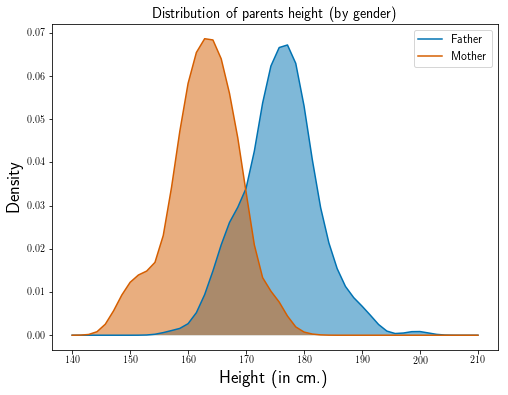

In [6]:
plt.figure()
kde_father = KDEUnivariate(df['Father'])
kde_father.fit(bw=2, kernel='gau')
x_grid = np.linspace(140, 210)
pdf_est_father = kde_father.evaluate(x_grid)

kde_mother = KDEUnivariate(df['Mother'])
kde_mother.fit(bw=2, kernel='gau')
x_grid = np.linspace(140, 210)
pdf_est_mother = kde_mother.evaluate(x_grid)

plt.plot(x_grid, pdf_est_father, color=my_blue, label='Father')
plt.fill_between(x_grid, 0, pdf_est_father, facecolor=my_blue, alpha=0.5)

plt.plot(x_grid, pdf_est_mother, color=my_orange, label='Mother')
plt.fill_between(x_grid, 0, pdf_est_mother, facecolor=my_orange, alpha=0.5)

plt.ylabel('Density', fontsize=18)
plt.xlabel('Height (in cm.)', fontsize=18)
plt.title("Distribution of parents height (by gender)")
plt.legend()
plt.show()

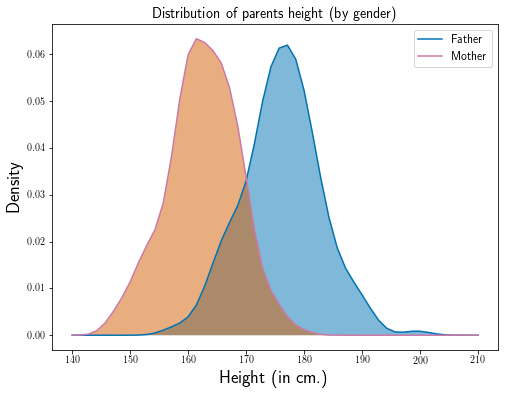

In [7]:
# Another possibility when the data has unique observations,
# with gaussian_kde from scipy.stats

father_unique = df['Father'].groupby(df['Family']).first()
mother_unique = df['Mother'].groupby(df['Family']).first()

plt.figure()
kde_father = gaussian_kde(father_unique)
x_grid = np.linspace(140, 210)
pdf_est_father = kde_father(x_grid)

kde_mother = gaussian_kde(mother_unique)
x_grid = np.linspace(140, 210)
pdf_est_mother = kde_mother(x_grid)

plt.plot(x_grid, pdf_est_father, color=my_blue, label='Father')
plt.fill_between(x_grid, 0, pdf_est_father, facecolor=my_blue, alpha=0.5)

plt.plot(x_grid, pdf_est_mother, color=my_purple, label='Mother')
plt.fill_between(x_grid, 0, pdf_est_mother, facecolor=my_orange, alpha=0.5)

plt.ylabel('Density', fontsize=18)
plt.xlabel('Height (in cm.)', fontsize=18)
plt.title("Distribution of parents height (by gender)")
plt.legend()
plt.show()

# Q4: Plot Father height as a function of Mother height, with OLS prediction
Afficher la taille du père en fonction de la taille de la mère pour les $n$ observations figurant dans les données. Ajouter la droite de prédiction obtenue par la méthode des moindres carrés (avec constante et sans centrage/normalisation).

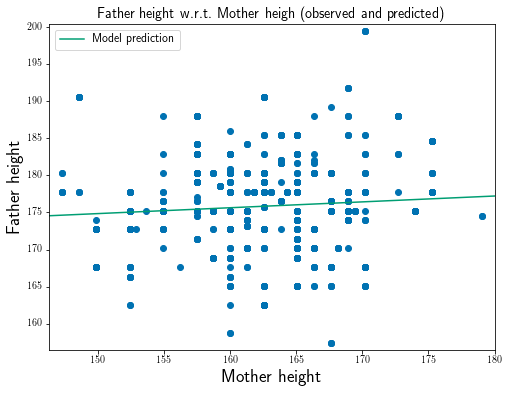

0.00542647493462


In [8]:
plt.figure()
y = df['Father']
X = df[['Mother']]
plt.plot(X, y, 'o',label="")
plt.ylabel('Father height', fontsize=18)
plt.ylim([df['Father'].min()-1, df['Father'].max()+1])
plt.xlim([df['Mother'].min()-1, df['Mother'].max()+1])
plt.xlabel('Mother height', fontsize=18)
skl_lm = linear_model.LinearRegression(fit_intercept=True)
skl_lm.fit(X, y)
plt.plot(x_grid, skl_lm.predict(x_grid.reshape(x_grid.shape[0], 1)), '-', label='Model prediction')
plt.legend()
plt.title("Father height w.r.t. Mother heigh (observed and predicted)")
plt.show()

print(skl_lm.score(X, y))  # it is pretty small...

# Q5: Distribution of the number of children by family 
Afficher un histogramme du nombre d'enfants par famille.

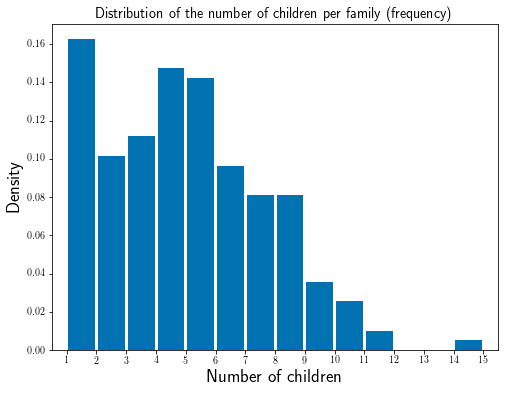

In [9]:
# second solution : normed=True
groupby_family = df['Family'].groupby(df['Family']).count()
plt.figure()
plt.hist(groupby_family, bins=14, normed=True, rwidth=0.9)
plt.xlim([0.5, 15.5])
plt.xticks(np.arange(1,16))
plt.xlabel('Number of children', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.title("Distribution of the number of children per family (frequency)")
plt.show()

There are 197 families


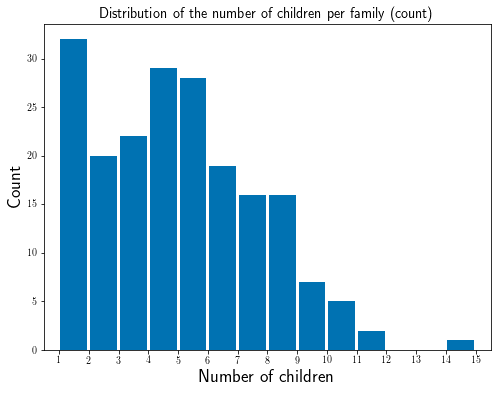

In [10]:
# second solution : normed=False
print("There are {} families".format(len(df['Family'].unique())))
groupby_family = df['Family'].groupby(df['Family']).count()
plt.figure()
plt.hist(groupby_family, bins=14, normed=False, rwidth=0.9)
plt.xlim([0.5, 15.5])
plt.xticks(np.arange(1,16))
plt.xlabel('Number of children', fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.title("Distribution of the number of children per family (count)")
plt.show()

# Q6: MidParents creation
Créer une colonne supplémentaire appelée *'MidParents'* qui contient la taille du sorte de "parent moyen", et valant ('Father'+ 1.08 * 'Mother') / 2.

In [11]:
df['MidParents'] = 0.5 * (df['Father'] + 1.08 * df['Mother'])

REM: The factor 1.08 gives a rescaled women's height variable which has the same average as the men's height. Indeed, the ratio of the average men's height over the average women's height is 

In [12]:
Ratio = np.mean(df['Father']) / np.mean(df['Mother'])

In [13]:
print(Ratio)

1.0803384317037383


Pour la $i^{ieme}$ observation, on note $x_i$ la taille du parent moyen et $y_i$ la taille de l'enfant. On se base sur le modèle linéaire suivant: $y_i = \theta_0 + \theta_1 x_i + \varepsilon_i$ et on suppose que les variables $\varepsilon_i$ sont centrées, indépendantes et de même variance $\sigma^2$ inconnue.

# Q7: Regression MidParents vs kids
Estimer $\theta_0$, $\theta_1$, par $\hat{\theta}_0$, $\hat{\theta}_1$ en utilisant la fonction **LinearRegression** de **sklearn**, puis vérifier numériquement (on pourra utiliser par exemple **np.isclose**)
les formules vues en cours pour le cas unidimensionnel:

$$
\hat\theta_0= \overline{y}_n -\hat{\theta}_1 \overline{x}_n,\qquad  \hat\theta_1=  \displaystyle\frac{ \sum_{i=1}^n (x_i-\overline{x}_n)(y_i -\overline{y}_n)}{\sum_{i=1}^n (x_i-\overline{x}_n)^2} .
$$

On fera attention aux normalisations utilisées pour la variance qui peuvent changer selon les packages.

In [14]:
X0 = df[['MidParents']]
y = df['Height']
skl_lm = linear_model.LinearRegression()
skl_lm.fit(X0, y)
theta0 = skl_lm.intercept_
theta1 = skl_lm.coef_[0]
y_mean = y.mean()
X0_mean = (X0.mean(axis=0)).squeeze()
X0_var = X0.var(ddof=0).squeeze()
y_var = y.var(ddof=0)
theta1_manual = ((X0.squeeze() - X0_mean) * (y - y_mean)).mean() / X0_var
theta0_manual = y_mean - theta1_manual * X0_mean
print(theta1)
print(theta1_manual)

print('Are the two computations of theta1' +
      ' the same? This is {} and theta1={}'.format(np.isclose(theta1, theta1_manual),theta1))

print('Are the two computations of theta0' +
      ' the same? This is {}, and theta0={}'.format(np.isclose(theta0, theta0_manual),theta0))

0.641190379591
0.641190379591
Are the two computations of theta1 the same? This is True and theta1=0.6411903795908169
Are the two computations of theta0 the same? This is True, and theta0=56.83556243483079


# Q8: Compute and display predictions with different colors by gender
Calculer et visualiser les valeurs prédites $\hat y_i = \hat\theta_0 + \hat\theta_1 x_i $ et les $y_i$ sur un même graphique. On affichera de deux couleurs différentes les garçons et les filles.

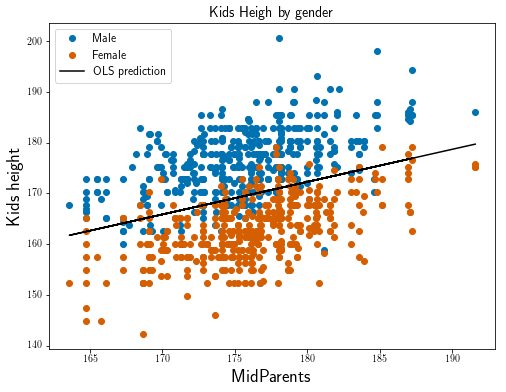

In [15]:
male = df['Gender'] == 'M'
female = df['Gender'] == 'F'
fig = plt.figure()
plt.plot(df['MidParents'][male], y[male], 'o', c=my_blue, label="Male")
plt.plot(df['MidParents'][female], y[female], 'o', c=my_orange, label="Female")
plt.plot(X0, skl_lm.predict(X0), label='OLS prediction', c='k')
plt.xlabel('MidParents', fontsize=18)
plt.ylabel('Kids height', fontsize=18)
plt.title("Kids Heigh by gender")
plt.legend()
plt.show()

# Q9: Residual density estimation

Visualiser un estimateur de la densité des résidus $r_i = y_i -\hat y_i$. L’hypothèse de normalité est-elle crédible selon vous? On ajoutera ensuite un estimateur par genre de la densité des résidus (en mettant un facteur proportionnel au nombre de personnes de chaque genre).

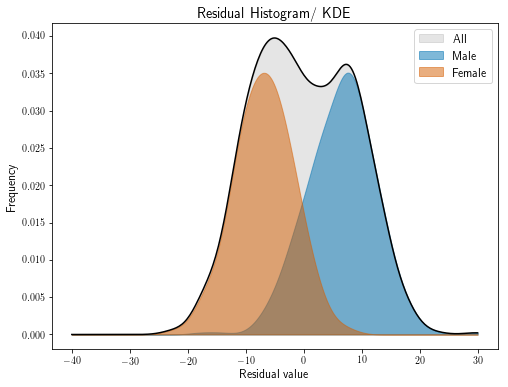

In [16]:
nb_f = float(female.sum())
nb_m = float(male.sum())
alpha_f = nb_f / (nb_f + nb_m)
alpha_m = nb_m / (nb_f + nb_m)

plt.figure()
residual = y - skl_lm.predict(X0)
x_grid = np.linspace(-40, 30, num=300)
plt.title('Residual Histogram/ KDE')
plt.xlabel('Residual value')
plt.ylabel('Frequency')

kde_residual = KDEUnivariate(residual)
kde_residual.fit(bw=2, kernel='gau')
pdf_est_residual = kde_residual.evaluate(x_grid)
plt.plot(x_grid, pdf_est_residual, color='k')
plt.fill_between(x_grid, pdf_est_residual, alpha=0.1, color='k', label='All')


kde_residual_m = KDEUnivariate(residual[male])
kde_residual_m.fit(bw=2, kernel='gau')
pdf_est_residual_m = kde_residual_m.evaluate(x_grid)
plt.fill_between(x_grid, alpha_m * pdf_est_residual_m, color=my_blue, alpha=0.5,label='Male')


kde_residual_f = KDEUnivariate(residual[female])
kde_residual_f.fit(bw=2, kernel='gau')
pdf_est_residual_f = kde_residual_f.evaluate(x_grid)
plt.fill_between(x_grid, alpha_f * pdf_est_residual_f, color=my_orange, alpha=0.5,label='Female')


plt.legend()
plt.show()

L’hypothèse de normalité globale des résidus n'est pas crédible (distribution bimodale). Cependant elle semble plus raisonnable si l'on fait l'étude séparement par genre.

# Q10 : Inverting the model
Régresser cette fois les $x_i$ sur les $y_i$ (et non plus les $y_i$ sur les $x_i$). Comparer les coefficients $\hat{\alpha}_0$ et $\hat{\alpha}_1$  obtenus par rapport aux $\hat{\theta}_0$ et $\hat{\theta}_1$ du modèle original. Vérifier numériquement que:
$$
\begin{cases}
\hat{\alpha}_0=&\bar{x}_n+\displaystyle\frac{\bar{y}_n}{\bar{x}_n}\frac{var_n(x)}{var_n(y)}
(\hat{\theta}_0-\bar{y}_n), \\
\hat{\alpha}_1=&\frac{var_n(x)}{var_n(y)} \hat{\theta}_1 .
\end{cases}
$$

In [17]:
skl_lm = linear_model.LinearRegression()
skl_lm.fit(df[['Height']], df['MidParents'])
alpha0 = skl_lm.intercept_
alpha1 = skl_lm.coef_[0]
alpha0_manual = X0_mean + y_mean / X0_mean * X0_var / y_var * (theta0 - y_mean)
alpha1_manual = X0_var / y_var * theta1_manual
print(alpha1)
print(alpha1_manual)

print('Are the two computations of alpha1' +
      ' the same? This is {}'.format(np.isclose(alpha1, alpha1_manual)))

print('Are the two computations of alpha0' +
      ' the same? This is {}'.format(np.isclose(alpha0, alpha0_manual)))


0.165038310213
0.165038310213
Are the two computations of alpha1 the same? This is True
Are the two computations of alpha0 the same? This is True


# EXERCISE 2



On travaille dans cette partie sur le fichier **auto-mpg.data**.
On cherche à régresser linéairement la consommation des voitures sur leurs caractéristiques: nombre de cylindres, cylindrées (*engine displacement* en anglais), puissance, poids, accélération, année, pays d'origine et le nom de la voiture.

Le vecteur contenant la consommation des voitures (plus précisément la distance parcourue, en miles, pour un gallon, ou mpg) est noté $y$; les colonnes de $X$ sont les régresseurs quantitatifs, donc pour le moment on laisse de côté les variables *origin* et *car name*.



# Q11: auto-mpg.data-original loading

Importer avec **Pandas** la base de données disponible ici https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original.

On ajoutera le nom des colonnes en consultant l'adresse:
https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names avec l'attribut **'name'** de **read_csv**. On pourra regarder l’intérêt de l'option **sep=r"\s\+"** si besoin.

Y a-t-il un marqueur utilisé pour les données manquantes dans le fichier utilisé? Si besoin, enlever les lignes possédant des valeurs manquantes dans la base de données.

In [18]:
# Load data
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/' +\
#       'auto-mpg.data-original'

# Alternative URL when UCI is down:
url = 'http://josephsalmon.eu/enseignement/TELECOM/MDI720/datasets/auto-mpg.data-original'

u_cols = ['mpg', 'cylinders', 'displacement', 'horsepower',
          'weight', 'acceleration', 'model_year', 'origin', 'car_name']

# To get correct display format
pd.options.display.float_format = '{:,.0f}'.format


# for this dataset na_values are marked as NA.
data = pd.read_csv(url, sep=r"\s+", names=u_cols, na_values='NA')
n_samples_ini = data.shape[0]
print("The original dataset has {} samples and {} features".format(
    data.shape[0], data.shape[1]))

# Remove NA:
data = data.dropna(axis=0, how='any')
n_samples = data.shape[0]
data.head()

# To get origin with meaningful names
origins = data['origin'].astype(str)
origins = origins.str.replace('1.0', '1USA')
origins = origins.str.replace('2.0', '2Europe')
origins = origins.str.replace('3.0', '3Japan')
data['origin'] = origins
data.head()

The original dataset has 406 samples and 9 features


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18,8,307,130,"3,504",12,70,1USA,chevrolet chevelle malibu
1,15,8,350,165,"3,693",12,70,1USA,buick skylark 320
2,18,8,318,150,"3,436",11,70,1USA,plymouth satellite
3,16,8,304,150,"3,433",12,70,1USA,amc rebel sst
4,17,8,302,140,"3,449",10,70,1USA,ford torino


In [19]:
print("There are {} missing values (NA).".format(n_samples_ini - n_samples))

There are 14 missing values (NA).


# Q12: OLS over a subset of the dataset

Calculer l'estimateur des moindres carrés (avec ordonnée à l'origine) $\hat\theta$ et sa prédiction $\hat{y}$ sur une sous partie de la base obtenue en gardant les $9$ premières lignes. Que constatez-vous pour les variables **cylinders** et **model year**?

In [20]:
y = data['mpg']
# data.drop(['mpg'], axis=1)
X_partial = data.drop(['origin', 'car_name', 'mpg'], axis=1)

# Fit regression model (with sklearn) degenerate case
skl_linmod = linear_model.LinearRegression()
skl_linmod.fit(X_partial[:9], y[:9])

print(X_partial.columns)
print(skl_linmod.coef_)
print(skl_linmod.intercept_)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year'],
      dtype='object')
[ 0.          0.05408848 -0.0945306  -0.00424074 -0.19936701  0.        ]
30.7716953656


Les coefficients des variables **cylinders** et **model year** sont nuls. Ceci est étrange, et vient du fait que le modèle est mal specifié. En effet, pour cette sous-partie de la base les colonnes de ces deux variables sont constantes et sont donc redondantes avec la colonnes constantes.

# Q13: OLS over a full dataset after rescaling/centering

Calculer $\hat\theta$ et $\hat y$ cette fois sur l'intégralité des données, après les avoir centrées et réduites. Quelles sont les deux variables qui expliquent le plus la consommation d'un véhicule selon vous?

In [21]:
# Fit regression model (with sklearn)
skl_linmod = linear_model.LinearRegression()
scaler = StandardScaler().fit(X_partial)
X = scaler.transform(X_partial)
skl_linmod.fit(X, y)

print(X_partial.columns)
print(skl_linmod.coef_)
# print(skl_linmod.intercept_)
ranked_variables = np.argsort(np.abs(skl_linmod.coef_))
print(X_partial.columns[ranked_variables[-2:]])

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year'],
      dtype='object')
[-0.56194996  0.80247616 -0.0150445  -5.76399971  0.23495704  2.77166415]
Index(['model_year', 'weight'], dtype='object')


Les deux variables qui semblent les plus explicative de la consomation (d'après l'amplitudes de leurs coefficients de régression) sont l'ancienneté (**model year**) et le poids (**weight**) de la voiture.

# Q14: Residual

Calculer $\|r\|^2$ (le carré de la norme du vecteur des résidus),
 puis $\|r\|^2/(n-p)$. Vérifier numériquement que:
 
\begin{equation*}
 \| y - \bar{y}_n\mathbf{1}_n\|^2=\|r\|^2 +\| \hat{y} - \bar{y}_n \mathbf{1}_n\|^2.
\end{equation*}


In [22]:
residual = skl_linmod.predict(X) - y
term_1 = np.linalg.norm(y - np.mean(y)) ** 2
term_2 = np.linalg.norm(residual) ** 2
term_3 = np.linalg.norm(skl_linmod.predict(X) - np.mean(y)) ** 2
print(np.isclose(term_1, term_2 + term_3))
print(term_1)

True
23818.9934694


# Q15: New observation

Supposons que l'on vous fournisse les caractéristiques suivantes d'un nouveau véhicule :

| cylinders  | displacement| horsepower | weight  | acceleration  |year|
|---|---|---|---|---|---|
| 6  | 225 | 100  | 3233  |15.4| 76

Prédire sa consommation (pour information, la consommation effectivement mesurée sur cet exemple était de 22 mpg).

In [23]:
X_new = np.array([[6, 225, 100, 3233, 15.4, 76]])
prediction_new = skl_linmod.predict(scaler.transform(X_new))[0]
print("The consumption predicted is {} mpg.".format(prediction_new))
print("This is {:.4}% away from the proposed value.".format(
    (100 - (prediction_new / 22. * 100))))

The consumption predicted is 21.776220182609453 mpg.
This is 1.017% away from the proposed value.


# Q16: Polynomial features.

Utiliser la transformation **PolynomialFeatures** de **sklearn** sur les données brutes, pour ajuster un modèle d'ordre deux (avec les termes d'interactions: **interaction_only=False**). On normalisera et recentrera après avoir créé les nouvelles variables explicatives. Quelle est alors la variable la plus explicative de la consomation?

In [24]:
poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
poly.fit(X_partial)
XX = poly.transform(X_partial) 
all_names = poly.get_feature_names(X_partial.columns)

scalerXX = StandardScaler().fit(XX)
XX = scalerXX.transform(XX)
skl_linmod.fit(XX, y)
print(all_names)
print(skl_linmod.coef_)
print(skl_linmod.intercept_)

['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'cylinders^2', 'cylinders displacement', 'cylinders horsepower', 'cylinders weight', 'cylinders acceleration', 'cylinders model_year', 'displacement^2', 'displacement horsepower', 'displacement weight', 'displacement acceleration', 'displacement model_year', 'horsepower^2', 'horsepower weight', 'horsepower acceleration', 'horsepower model_year', 'weight^2', 'weight acceleration', 'weight model_year', 'acceleration^2', 'acceleration model_year', 'model_year^2']
[ 13.34357536 -48.43391341   5.15417707  17.47091667 -16.05072528
 -26.88104821  -8.13486673  -2.94736774  11.95174218   5.33737455
   4.87668634 -16.22928128   1.29969118   3.38005168   5.2047413
  -3.29326443  43.68431432  -3.59171565  -6.15116573  -2.38675585
  -4.85057027   3.15822997   0.84918913 -25.11606269   1.99403567
  13.91361302  29.84851135]
23.4459183673


In [25]:
rank_variables = np.argsort(np.abs(skl_linmod.coef_))[::-1]
print([all_names[i] for i in rank_variables])

['displacement', 'displacement model_year', 'model_year^2', 'model_year', 'weight model_year', 'weight', 'cylinders model_year', 'acceleration', 'acceleration model_year', 'cylinders', 'cylinders horsepower', 'cylinders^2', 'horsepower weight', 'cylinders weight', 'displacement weight', 'horsepower', 'cylinders acceleration', 'horsepower model_year', 'horsepower^2', 'displacement horsepower', 'displacement acceleration', 'weight^2', 'cylinders displacement', 'horsepower acceleration', 'acceleration^2', 'displacement^2', 'weight acceleration']


Cette fois la variable la plus pertinente semble être "displacement". C'est un paradoxe classique: en ajoutant de nouvelles variables (ici les produits de variables), il se peut que le classement par ordre d'influence des variables (mesuré par l'amplitude des coefficients) change. Ce problème est partiellement résolu par sélection de variables.

In [26]:
# BEWARE: it might lead to different interpretation if one perform the steps:
# 1) center/rescale the design matrix
# 2) create the interaction features
# 3) center/rescale the new design matrix
# or
# 1) create the interaction features
# 2) center/rescale the new design matrix.
# The most reasonable is to rather proceed as proposed above (ie 2nd choice)

# Q 17: Handling origins

On revient ici au modèle sans interactions. Proposer une manière de gérer la variable"origin" par exemple avec **pd.get_dummies**. On ajustera un modèle linéaire sans constante dans ce cas. Déterminer laquelle des trois origines est la plus efficace en terme de consommation (Pour info, 1 = usa; 2 = europe; 3 = japan).

In [27]:
# Solution 1: all origins, no intercpet, no rescalling.
X_origin1 = data.copy().drop(['car_name', 'mpg'], axis=1)
X_origin1 = pd.get_dummies(X_origin1, columns=['origin'])

scaler = StandardScaler(with_mean=False,with_std=False).fit(X_origin1)
Z1 = scaler.transform(X_origin1)

skl_linmod1 = linear_model.LinearRegression(fit_intercept=False)
skl_linmod1.fit(Z1, y)

print(X_origin1.columns[6:])
print(skl_linmod1.coef_[6:])

Index(['origin_1USA', 'origin_2Europe', 'origin_3Japan'], dtype='object')
[-17.95460207 -15.32459971 -15.10137384]


**Conclusion**: Result sugest that Japan is the most efficient, then come Europe, and USA is far behind.

In [28]:
# Solution 2: removing USA, and considering an intercpet
X_origin2 = data.copy().drop(['car_name', 'mpg'], axis=1)
X_origin2 = pd.get_dummies(X_origin2, columns=['origin'],drop_first=True)

scaler = StandardScaler(with_mean=False,with_std=False).fit(X_origin2)
Z2 = scaler.transform(X_origin2)

skl_linmod2 = linear_model.LinearRegression(fit_intercept=True)
skl_linmod2.fit(Z2, y)

print(X_origin2.columns[:])
print(skl_linmod2.coef_[6:])

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year', 'origin_2Europe', 'origin_3Japan'],
      dtype='object')
[ 2.63000236  2.85322823]


In [29]:
# Testing link between models:
Europe_cst = skl_linmod2.intercept_
testing_coef = np.concatenate(
    [skl_linmod2.coef_[:6],  [Europe_cst], skl_linmod2.coef_[6:] + Europe_cst])
print(np.allclose(testing_coef, skl_linmod1.coef_))

True


**Conclusion**: Japon is still the most efficent then w.r.t. Europe (positive coefficient), and USA is less efficient than Europe (negative coefficient).

In [30]:
# Solution 3: normalizing all columns implies that a post-processing is needed:
# to get meaningfull coefficient, scaling is required!
origines_count = data['origin'].value_counts()
print(origines_count)

X_origin3 = data.copy().drop(['car_name', 'mpg'], axis=1)
X_origin3 = pd.get_dummies(X_origin3, columns=['origin'], drop_first=False)

scaler = StandardScaler(with_mean=False, with_std=True).fit(X_origin3)
Z3 = scaler.transform(X_origin3)

skl_linmod3 = linear_model.LinearRegression(fit_intercept=False)
skl_linmod3.fit(Z3, y)

print(X_origin3.columns[6:])
print(skl_linmod3.coef_[6:])
print(skl_linmod3.coef_)

1USA       245
3Japan      79
2Europe     68
Name: origin, dtype: int64
Index(['origin_1USA', 'origin_2Europe', 'origin_3Japan'], dtype='object')
[-8.69223435 -5.80269887 -6.05781639]
[-0.83427197  2.50601874 -0.69900932 -5.69254264  0.21795599  2.85870923
 -8.69223435 -5.80269887 -6.05781639]


Beware: the result above wrongly suggests Europe is the best. But this is a scaling issue:

In [31]:
print(skl_linmod3.coef_[6:] / scaler.scale_[6:])
print(np.allclose(skl_linmod3.coef_ / scaler.scale_, skl_linmod1.coef_))

# Europe has more variability : because it has fewer samples
print(scaler.scale_[6:])

[-17.95460207 -15.32459971 -15.10137384]
True
[ 0.48412292  0.37865256  0.4011434 ]


**Conclusion**: we recover the same conclusion after a careful normalisation...

In [32]:
# best is to check t-statistics NOT the coefficients themselves:
# cf. William H. Greene, Econometric analysis, Prentice Hall (2003), page 79, 4-14
# cf. http://josephsalmon.eu/enseignement/TELECOM/MDI720/IntroTests_fr.pdf

results = sm.OLS(y, Z1).fit()
print(X_origin1.columns[:])
print(results.tvalues.values)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year', 'origin_1USA', 'origin_2Europe', 'origin_3Japan'],
      dtype='object')
[ -1.52447816   3.13312444  -1.32642763 -10.24277927   0.80537819
  15.00512974  -3.83896851  -3.32972233  -3.22628516]


**Conclusion**: the order is still Japan>Europe>USA

# Q18: Handling brands with some text processing

Procéder de même cette fois en fonction de la marque de la voiture.
On pourra utiliser **str.split** et **str.replace** pour créer une nouvelle variable **'brand'**.

In [33]:
car_names = data['car_name']
brands = pd.Series(car_names.str.split().str.get(0))


# A bit of cleaning:
brands = brands.str.replace('volkswagen', 'vw', case=False)
brands = brands.str.replace('vokswagen', 'vw', case=False)
brands = brands.str.replace('toyouta', 'toyota', case=False)
brands = brands.str.replace('maxda', 'mazda', case=False)
brands = brands.str.replace('chevy', 'chevrolet', case=False)
brands = brands.str.replace('chevroelt', 'chevrolet', case=False)
brands = brands.str.replace('mercedes-benz', 'mercedes', case=False)
brands = brands.str.replace('capri', 'ford', case=False)
brands = brands.str.replace('datsun', 'nissan', case=False)
brands = brands.str.replace('dodge', 'chrysler', case=False)


data['brand'] = pd.Series(brands)
X_brand = data.drop(['car_name', 'mpg', 'origin'], axis=1)
X_brand = pd.get_dummies(X_brand, columns=['brand'], drop_first=False)

# NOTE: the first in alphabetical order is amc: if drop_first=True, that's the one removed.
print("Number of cars per brand:")
print(data['brand'].value_counts())


scaler = StandardScaler(with_mean=False, with_std=False).fit(X_brand)
X_brand_scaled = scaler.transform(X_brand)

skl_linmod = linear_model.LinearRegression(fit_intercept=False)
skl_linmod.fit(X_brand_scaled, y)

# sort by negative influence over the coefficients:
brands = X_brand.columns[6:]
coef_brands = skl_linmod.coef_[6:]
rank_variables = np.argsort(coef_brands)

print("")
print("Brands by increasing coefficients:")
print(brands[rank_variables])
print(coef_brands[rank_variables])

Number of cars per brand:
ford          49
chevrolet     47
chrysler      34
plymouth      31
amc           27
toyota        26
nissan        24
vw            22
buick         17
pontiac       16
honda         13
mazda         12
mercury       11
oldsmobile    10
fiat           8
peugeot        8
audi           7
volvo          6
opel           4
subaru         4
saab           4
renault        3
mercedes       3
bmw            2
cadillac       2
triumph        1
hi             1
Name: brand, dtype: int64

Brands by increasing coefficients:
Index(['brand_amc', 'brand_mercury', 'brand_ford', 'brand_buick',
       'brand_chevrolet', 'brand_volvo', 'brand_chrysler', 'brand_opel',
       'brand_bmw', 'brand_oldsmobile', 'brand_plymouth', 'brand_pontiac',
       'brand_mazda', 'brand_saab', 'brand_subaru', 'brand_toyota',
       'brand_peugeot', 'brand_cadillac', 'brand_audi', 'brand_renault',
       'brand_hi', 'brand_mercedes', 'brand_fiat', 'brand_vw', 'brand_honda',
       'brand_nissan

In [34]:
# Sorted by negative influence over the tvalues:

results = sm.OLS(y, X_brand_scaled).fit()
brands = X_brand.columns[6:]
ttest_brands = results.tvalues.values[6:]
rank_variables = np.argsort(ttest_brands)

print(brands[rank_variables])
print(ttest_brands[rank_variables])

Index(['brand_amc', 'brand_ford', 'brand_mercury', 'brand_chevrolet',
       'brand_buick', 'brand_volvo', 'brand_chrysler', 'brand_opel',
       'brand_plymouth', 'brand_bmw', 'brand_oldsmobile', 'brand_pontiac',
       'brand_toyota', 'brand_mazda', 'brand_saab', 'brand_peugeot',
       'brand_subaru', 'brand_audi', 'brand_fiat', 'brand_vw', 'brand_renault',
       'brand_honda', 'brand_mercedes', 'brand_cadillac', 'brand_nissan',
       'brand_hi', 'brand_triumph'],
      dtype='object')
[-3.24363016 -3.0706495  -3.04164157 -2.93096041 -2.84541389 -2.8103812
 -2.80314176 -2.7449872  -2.66925169 -2.57678996 -2.56807667 -2.56645127
 -2.5293144  -2.52610382 -2.45373763 -2.40481246 -2.39941372 -2.35765008
 -2.29523846 -2.24301229 -2.23016877 -2.14972989 -2.08367061 -2.07656736
 -2.02414966 -1.80671684 -1.23027746]


The most favorable influence is from the **triumph** brand, but the worst is coming from **amc**.

In [35]:
# Illustration of what would be the prediction for one car if the brand
# was substituted by another one. This will illustrate that the Triumph
# "would" make a more efficient car that any other brand for the car
# considered.

brands_df = pd.Series(brands, name="brands").str.replace('brand_', '', case=False)
for  i, brand_name in enumerate(brands_df):
    X_to_pred = X_brand_scaled[28].copy()
    X_to_pred[6 + 9] = 0.
    X_to_pred[6 + i] = 1.

    print("If the hi car's brand was {}, \n then instead of {}, the its consumption would be {:.4}".format(brand_name, y.iloc[28],
    skl_linmod.predict(X_to_pred.reshape(1, -1))[0]))

If the hi car's brand was amc, 
 then instead of 9.0, the its consumption would be 4.44
If the hi car's brand was audi, 
 then instead of 9.0, the its consumption would be 8.54
If the hi car's brand was bmw, 
 then instead of 9.0, the its consumption would be 6.702
If the hi car's brand was buick, 
 then instead of 9.0, the its consumption would be 5.782
If the hi car's brand was cadillac, 
 then instead of 9.0, the its consumption would be 8.5
If the hi car's brand was chevrolet, 
 then instead of 9.0, the its consumption would be 5.799
If the hi car's brand was chrysler, 
 then instead of 9.0, the its consumption would be 6.242
If the hi car's brand was fiat, 
 then instead of 9.0, the its consumption would be 9.184
If the hi car's brand was ford, 
 then instead of 9.0, the its consumption would be 5.196
If the hi car's brand was hi, 
 then instead of 9.0, the its consumption would be 9.0
If the hi car's brand was honda, 
 then instead of 9.0, the its consumption would be 9.548
If th

Pour aller plus loin : https://perso.univ-rennes1.fr/bernard.delyon/regression.pdf ( I.2.8 Traitement des variables catégorielles)

# Q19
Reprendre la matrice $X$ obtenue sans variables catégorielles. Obtenez numériquement la SVD (partielle) de $X = U S V^\top$ (par exemple en considérant l'option **full_matrices=False**); vérifier numériquement que $H = U U^\top $ est une projection orthogonale (on admettra si besoin que c'est la matrice chapeau, H, vue en cours).

In [36]:
# TODO: TO improve and may be give a standard threshold as in Delyon ...
U, s, V = svd(X, full_matrices=False)
proj_mat = np.dot(U, U.T)
print(np.allclose(proj_mat.dot(proj_mat), proj_mat))
print(np.allclose(proj_mat.T, proj_mat))

# Rem: Note that the centering/rescaling step does not modify the leverage.

leverage = np.diag(proj_mat)
data['leverage'] = leverage

True
True


# Q20:
La diagonale de la matrice $H$, forme le vecteur des "leviers", qu'on ajoutera comme nouvelle variable. Trier la base de données en fonction de cette variable, et expliquer en quoi les voitures ayant les trois valeurs de "levier" les plus grandes semblent atypiques.

In [37]:
data = data.sort_values(['leverage'], ascending=False)
display(HTML(data.describe().to_html(formatters={'leverage': '{:,.3f}'.format})))
display(HTML(data.head(6).to_html(formatters={'leverage': '{:,.3f}'.format})))

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,leverage
count,392,392,392,392,392,392,392,392.000
mean,23,5,194,104,"2,978",16,76,0.015
std,8,2,105,38,849,3,4,0.014
min,9,3,68,46,"1,613",8,70,0.002
25%,17,4,105,75,"2,225",14,73,0.008
50%,23,4,151,94,"2,804",16,76,0.012
75%,29,8,276,126,"3,615",17,79,0.018
max,47,8,455,230,"5,140",25,82,0.187


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,brand,leverage
19,14,8,455,225,"3,086",10,70,1USA,buick estate wagon (sw),buick,0.187
34,9,8,304,193,"4,732",18,70,1USA,hi 1200d,hi,0.085
32,10,8,307,200,"4,376",15,70,1USA,chevy c20,chevrolet,0.062
33,11,8,318,210,"4,382",14,70,1USA,dodge d200,chrysler,0.061
8,14,8,455,225,"4,425",10,70,1USA,pontiac catalina,pontiac,0.059
307,24,8,260,90,"3,420",22,79,1USA,oldsmobile cutlass salon brougham,oldsmobile,0.055


Conclusion:
- L'observation de levier maximum a des valeurs extrêmes pour: 'cylinders', 'displacement' et 'model_year'
- L'observation de deuxième levier maximum a des valeurs extrêmes pour: 'cylinders', 'weight', 'acceleration', 'horsepower' et 'model_year'
- L'observation de deuxième levier maximum a des valeurs extrêmes pour: 'cylinders', 'horsepower', 'weight' and 'model_year'

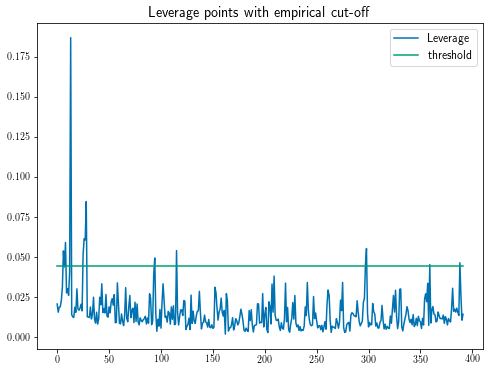

In [38]:
# Bonus:  visualisation of the leverage points with empirical cut-off for "large" leverage points
threshold = 2.5 * (float(X.shape[1] + 1) / float(X.shape[0]))

plt.figure()
plt.plot(np.arange(X.shape[0]), leverage, label="Leverage")
plt.plot(np.arange(X.shape[0]), threshold * np.ones(X.shape[0]), label="threshold")
plt.legend()
plt.title("Leverage points with empirical cut-off")
plt.show()